In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import seaborn as sns
%matplotlib inline
# %matplotlib notebook # uncomment for interactivity
from matplotlib import pyplot as plt
from sklearn.covariance import empirical_covariance
pd.options.display.max_columns = None
pd.options.mode.chained_assignment = None  # default='warn'
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

### 1. Data Preparation

In [2]:
data = pd.read_excel("efw-2020-master-index-data-for-researchers.xlsx", header=[4])
data = data.iloc[:,1:]
data = data.iloc[:,:72]
data = data[data.columns.drop(list(data.filter(regex='data')))]

In [3]:
# just look at year 2018
data_2018 = data[data['Year']==2018.0]
# data_2018 = data_2018.drop(columns=five_major_areas)
# data_2018 = data_2018.drop(columns=sub_areas)
data_2018.head(10)

,Year,ISO_Code,Countries,Economic Freedom Summary Index,Rank,Quartile,Government consumption,Transfers and subsidies,Government investment,Top marginal income tax rate,Top marginal income and payroll tax rate,Top marginal tax rate,State ownership of assets,Size of Government,Judicial independence,Impartial courts,Protection of property rights,Military interference in rule of law and politics,Integrity of the legal system,Legal enforcement of contracts,Regulatory restrictions on the sale of real property,Reliability of police,Gender Legal Rights Adjustment,Legal System & Property Rights,Money growth,Standard deviation of inflation,Inflation: Most recent year,Freedom to own foreign currency bank accounts,Sound Money,Revenue from trade taxes (% of trade sector),Mean tariff rate,Standard deviation of tariff rates,Tariffs,Non-tariff trade barriers,Compliance costs of importing and exporting,Regulatory trade barriers,Black market exchange rates,Financial Openness,Capital controls,Freedom of foreigners to visit,Controls of the movement of capital and people,Freedom to Trade Internationally,Ownership of banks,Private sector credit,Interest rate controls/negative real interest rates),Credit market regulations,Hiring regulations and minimum wage,Hiring and firing regulations,Centralized collective bargaining,Hours Regulations,Mandated cost of worker dismissal,Conscription,Labor market regulations,Administrative requirements,Regulatory Burden,Starting a business,Impartial Public Administration,Licensing restrictions,Tax compliance,Business regulations,Regulation
0,2018.0,ALB,Albania,7.80,26.0,1.0,8.155882,6.738420,7.995416,9.0,7.0,8.0,9.538,8.085544,3.564791,3.651625,4.935262,8.3,5.707933,3.913506,6.715384,5.607842,0.9524,5.173414,9.957235,9.738327,9.594400,10.0,9.822491,9.666667,9.28,8.0992,9.015289,6.807307,9.405328,8.106317,10.0,4.164419,4.615385,8.296923,5.692242,8.203462,10.0,9.214878,10.0,9.738293,5.566667,4.865385,5.575783,8.0,6.29974,10.0,6.717929,5.651538,6.666667,9.742477,5.396,5.621940,7.175250,6.708979,7.721734
1,2018.0,DZA,Algeria,4.97,157.0,4.0,3.220588,7.817129,4.606816,7.0,2.0,4.5,1.064,4.241707,3.710710,4.108493,5.487307,4.2,4.694287,4.392092,6.626692,6.347414,0.8333,4.533636,9.596447,7.944070,9.146020,5.0,7.921634,8.480000,6.22,5.9176,6.872533,4.557608,0.479290,2.518449,0.0,1.657258,0.000000,1.106256,0.921172,2.578038,0.0,5.301526,10.0,5.100509,5.566667,5.028064,6.522477,6.0,7.75518,3.0,5.645397,4.215154,2.444444,9.305002,3.906,8.771111,7.029528,5.945207,5.563704
2,2018.0,AGO,Angola,4.75,159.0,4.0,7.698695,9.623978,6.326667,10.0,9.0,9.5,3.376,7.305068,3.167767,3.218124,4.174422,3.3,4.867423,2.302200,5.521625,3.806231,0.8095,3.433276,9.873492,2.980998,5.961926,0.0,4.704104,9.240000,8.16,4.4064,7.268800,4.695111,2.514793,3.604952,0.0,0.000000,2.307692,0.110626,0.806106,2.919964,5.0,6.533000,4.0,5.177667,10.000000,4.426570,6.969783,4.0,6.63276,0.0,5.338186,2.937894,2.444444,8.730805,5.044,7.916416,6.782923,5.642747,5.386200
3,2018.0,ARG,Argentina,5.78,144.0,4.0,5.938235,6.307902,7.586454,7.0,1.0,4.0,6.408,6.048118,4.268820,4.256857,5.633630,7.5,4.784467,3.816436,6.857195,4.411544,0.7857,4.634890,5.667184,6.453117,3.140000,5.0,5.065075,7.106667,7.28,5.9200,6.768889,5.070688,5.649711,5.360200,10.0,7.595233,6.923077,7.965046,7.494452,7.405885,5.0,4.259461,8.0,5.753154,2.766667,2.240387,3.192984,10.0,2.51725,10.0,5.119549,2.714233,6.666667,9.579288,7.202,5.726521,6.508295,6.399500,5.757401
4,2018.0,ARM,Armenia,7.92,18.0,1.0,7.717647,7.711172,9.296599,5.0,5.0,5.0,9.510,7.847084,4.014064,4.886363,6.024881,5.8,5.449060,5.196693,9.815935,6.669861,1.0000,5.982107,9.110175,9.617362,9.495953,10.0,9.555873,9.026667,8.70,7.5820,8.436222,5.689747,9.315389,7.502568,10.0,8.342742,5.384615,10.000000,7.909119,8.461977,10.0,8.639931,10.0,9.546644,6.666667,5.599639,7.248644,10.0,9.25173,0.0,6.461113,5.170406,6.000000,9.863530,6.298,9.302574,7.040738,7.279208,7.762321
5,2018.0,AUS,Australia,8.23,5.0,1.0,4.450000,6.867958,9.919000,6.0,5.0,5.5,7

In [4]:
# check null values
nullcol = data_2018.isnull().sum()
nullcol[nullcol != 0]

Transfers and subsidies                                  7
Government investment                                    9
Top marginal income and payroll tax rate                 4
State ownership of assets                                3
Protection of property rights                            1
Military interference in rule of law and politics       25
Integrity of the legal system                            1
Regulatory restrictions on the sale of real property     2
Reliability of police                                    5
Revenue from trade taxes (% of trade sector)             8
Mean tariff rate                                         2
Standard deviation of tariff rates                       2
Tariffs                                                  1
Non-tariff trade barriers                                2
Financial Openness                                       8
Capital controls                                         1
Freedom of foreigners to visit                          

In [5]:
five_major_areas = ['Size of Government','Legal System & Property Rights','Sound Money',
                   'Freedom to Trade Internationally', 'Regulation']
sub_areas = ['Tariffs', 'Regulatory trade barriers',
             'Controls of the movement of capital and people', 'Credit market regulations',
             'Business regulations', 'Labor market regulations']

In [6]:
# fill missing values using average values of (sub)categories

# area1
data_2018.loc[:,'State ownership of assets'] = data_2018.loc[:,'State ownership of assets'].fillna(data_2018['Size of Government'])
data_2018.loc[:,'Transfers and subsidies'] = data_2018.loc[:,'Transfers and subsidies'].fillna(data_2018['Size of Government'])
data_2018.loc[:,'Government investment'] = data_2018.loc[:,'Government investment'].fillna(data_2018['Size of Government'])
data_2018.loc[:,'Top marginal income and payroll tax rate'] = data_2018.loc[:,'Top marginal income and payroll tax rate'].fillna(data_2018['Top marginal tax rate'])

In [7]:
# area2
data_2018.loc[:,'Protection of property rights'] = data_2018.loc[:,'Protection of property rights'].fillna(data_2018['Legal System & Property Rights'])
data_2018.loc[:,'Military interference in rule of law and politics'] = data_2018.loc[:,'Military interference in rule of law and politics'].fillna(data_2018['Legal System & Property Rights'])
data_2018.loc[:,'Reliability of police'] = data_2018.loc[:,'Reliability of police'].fillna(data_2018['Legal System & Property Rights'])
data_2018.loc[:,'Regulatory restrictions on the sale of real property'] = data_2018.loc[:,'Regulatory restrictions on the sale of real property'].fillna(data_2018['Legal System & Property Rights'])
data_2018.loc[:,'Integrity of the legal system'] = data_2018.loc[:,'Integrity of the legal system'].fillna(data_2018['Legal System & Property Rights'])

In [8]:
# area4
data_2018.loc[:,'Revenue from trade taxes (% of trade sector)'] = data_2018.loc[:,'Revenue from trade taxes (% of trade sector)'].fillna(data_2018['Tariffs'])
data_2018.loc[:,'Mean tariff rate'] = data_2018.loc[:,'Mean tariff rate'].fillna(data_2018['Tariffs'])
data_2018.loc[:,'Standard deviation of tariff rates'] = data_2018.loc[:,'Standard deviation of tariff rates'].fillna(data_2018['Tariffs'])
data_2018.loc[:,'Non-tariff trade barriers'] = data_2018.loc[:,'Non-tariff trade barriers'].fillna(data_2018['Regulatory trade barriers'])
data_2018.loc[:,'Financial Openness'] = data_2018.loc[:,'Financial Openness'].fillna(data_2018['Controls of the movement of capital and people'])
data_2018.loc[:,'Capital controls'] = data_2018.loc[:,'Capital controls'].fillna(data_2018['Controls of the movement of capital and people'])
data_2018.loc[:,'Freedom of foreigners to visit'] = data_2018.loc[:,'Freedom of foreigners to visit'].fillna(data_2018['Controls of the movement of capital and people'])

# Libya has no value for all metrics under area 4.
# fill na with the value of "Freedom to Trade Internationally"
data_2018.loc[data_2018['Countries'] == "Libya",'Revenue from trade taxes (% of trade sector)'] = data_2018.loc[data_2018['Countries'] == "Libya",'Freedom to Trade Internationally']
data_2018.loc[data_2018['Countries'] == "Libya", 'Mean tariff rate'] = data_2018.loc[data_2018['Countries'] == "Libya", 'Freedom to Trade Internationally']
data_2018.loc[data_2018['Countries'] == "Libya", 'Standard deviation of tariff rates'] = data_2018.loc[data_2018['Countries'] == "Libya", 'Freedom to Trade Internationally']
data_2018.loc[data_2018['Countries'] == "Libya", 'Tariffs'] = data_2018.loc[data_2018['Countries'] == "Libya",'Freedom to Trade Internationally']

# data_2018[data_2018['Countries'] == "Libya"]

In [9]:
# area5
data_2018.loc[:,'Ownership of banks'] = data_2018.loc[:,'Ownership of banks'].fillna(data_2018['Credit market regulations'])
data_2018.loc[:,'Hiring and firing regulations'] = data_2018.loc[:,'Hiring and firing regulations'].fillna(data_2018['Labor market regulations'])
data_2018.loc[:,'Centralized collective bargaining'] = data_2018.loc[:,'Centralized collective bargaining'].fillna(data_2018['Labor market regulations'])
data_2018.loc[:,'Mandated cost of worker dismissal'] = data_2018.loc[:,'Mandated cost of worker dismissal'].fillna(data_2018['Labor market regulations'])
data_2018.loc[:,'Administrative requirements'] = data_2018.loc[:,'Administrative requirements'].fillna(data_2018['Business regulations'])
data_2018.loc[:,'Impartial Public Administration'] = data_2018.loc[:,'Impartial Public Administration'].fillna(data_2018['Business regulations'])
data_2018.loc[:,'Licensing restrictions'] = data_2018.loc[:,'Licensing restrictions'].fillna(data_2018['Business regulations'])

In [10]:
# make sure there is no null value
nullcol = data_2018.isnull().sum()
nullcol[nullcol != 0]

Series([], dtype: int64)

In [11]:
# drop areas and subareas which are essentially average values
# only look at 44 distinct variables
data_2018 = data_2018.drop(columns=five_major_areas)
data_2018 = data_2018.drop(columns=sub_areas)
data_2018.head()

,Year,ISO_Code,Countries,Economic Freedom Summary Index,Rank,Quartile,Government consumption,Transfers and subsidies,Government investment,Top marginal income tax rate,Top marginal income and payroll tax rate,Top marginal tax rate,State ownership of assets,Judicial independence,Impartial courts,Protection of property rights,Military interference in rule of law and politics,Integrity of the legal system,Legal enforcement of contracts,Regulatory restrictions on the sale of real property,Reliability of police,Gender Legal Rights Adjustment,Money growth,Standard deviation of inflation,Inflation: Most recent year,Freedom to own foreign currency bank accounts,Revenue from trade taxes (% of trade sector),Mean tariff rate,Standard deviation of tariff rates,Non-tariff trade barriers,Compliance costs of importing and exporting,Black market exchange rates,Financial Openness,Capital controls,Freedom of foreigners to visit,Ownership of banks,Private sector credit,Interest rate controls/negative real interest rates),Hiring regulations and minimum wage,Hiring and firing regulations,Centralized collective bargaining,Hours Regulations,Mandated cost of worker dismissal,Conscription,Administrative requirements,Regulatory Burden,Starting a business,Impartial Public Administration,Licensing restrictions,Tax compliance
0,2018.0,ALB,Albania,7.80,26.0,1.0,8.155882,6.738420,7.995416,9.0,7.0,8.0,9.538,3.564791,3.651625,4.935262,8.3,5.707933,3.913506,6.715384,5.607842,0.9524,9.957235,9.738327,9.594400,10.0,9.666667,9.28,8.0992,6.807307,9.405328,10.0,4.164419,4.615385,8.296923,10.0,9.214878,10.0,5.566667,4.865385,5.575783,8.0,6.299741,10.0,5.651538,6.666667,9.742477,5.396,5.621940,7.175250
1,2018.0,DZA,Algeria,4.97,157.0,4.0,3.220588,7.817129,4.606816,7.0,2.0,4.5,1.064,3.710710,4.108493,5.487307,4.2,4.694287,4.392092,6.626692,6.347414,0.8333,9.596447,7.944070,9.146020,5.0,8.480000,6.22,5.9176,4.557608,0.479290,0.0,1.657258,0.000000,1.106256,0.0,5.301526,10.0,5.566667,5.028064,6.522477,6.0,7.755176,3.0,4.215154,2.444444,9.305002,3.906,8.771111,7.029528
2,2018.0,AGO,Angola,4.75,159.0,4.0,7.698695,9.623978,6.326667,10.0,9.0,9.5,3.376,3.167767,3.218124,4.174422,3.3,4.867423,2.302200,5.521625,3.806231,0.8095,9.873492,2.980998,5.961926,0.0,9.240000,8.16,4.4064,4.695111,2.514793,0.0,0.000000,2.307692,0.110626,5.0,6.533000,4.0,10.000000,4.426570,6.969783,4.0,6.632764,0.0,2.937894,2.444444,8.730805,5.044,7.916416,6.782923
3,2018.0,ARG,Argentina,5.78,144.0,4.0,5.938235,6.307902,7.586454,7.0,1.0,4.0,6.408,4.268820,4.256857,5.633630,7.5,4.784467,3.816436,6.857195,4.411544,0.7857,5.667184,6.453117,3.140000,5.0,7.106667,7.28,5.9200,5.070688,5.649711,10.0,7.595233,6.923077,7.965046,5.0,4.259461,8.0,2.766667,2.240387,3.192984,10.0,2.517254,10.0,2.714233,6.666667,9.579288,7.202,5.726521,6.508295
4,2018.0,ARM,Armenia,7.92,18.0,1.0,7.717647,7.711172,9.296599,5.0,5.0,5.0,9.510,4.014064,4.886363,6.024881,5.8,5.449060,5.196693,9.815935,6.669861,1.0000,9.110175,9.617362,9.495953,10.0,9.026667,8.70,7.5820,5.689747,9.315389,10.0,8.342742,5.384615,10.000000,10.0,8.639931,10.0,6.666667,5.599639,7.248644,10.0,9.251725,0.0,5.170406,6.000000,9.863530,6.298,9.302574,7.040738


In [35]:
data_2018.shape

(162, 50)

### 2. PCA Analysis

In [12]:
# usd PCA to reduce 44 variables to 23 dimensions which explains 90% 
# of the variance in the data

X = data_2018.iloc[:, 6:]
q = data_2018['Quartile']

In [13]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [14]:
RANDOM_STATE = 42
pca = PCA(n_components=0.9, random_state=RANDOM_STATE).fit(X_scaled)
X_pca = pca.transform(X_scaled)

In [15]:
print(f'X :{X_scaled.shape}')
print(f'X reduced:{X_pca.shape}')
print(f'the first component explains{pca.explained_variance_ratio_[0]*100 : .0f} percent of the data')
print(f'the second component explains{pca.explained_variance_ratio_[1]*100 : .0f} percent of the data')

X :(162, 44)
X reduced:(162, 23)
the first component explains 28 percent of the data
the second component explains 9 percent of the data


In [16]:
#sns.heatmap(empirical_covariance(X_scaled))

#### We can see that majority of the countries in quartile 1 and 2 are positioned on the left side of the plane. The rest of the countries in quartile 3 and 4 are positioned on the right side of the plane.

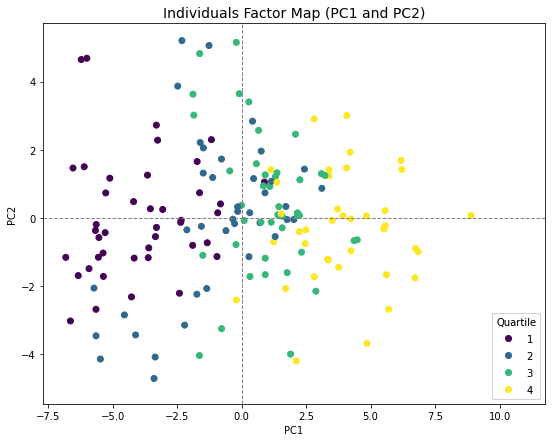

In [17]:
# Visualize the data in the projection on the first two main components.

fig, ax = plt.subplots(figsize=(9, 7))
scatter = ax.scatter(X_pca[:,0], X_pca[:,1], c=q)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower right", title="Quartile")
ax.add_artist(legend1)
plt.axvline(0, linewidth=1, color='grey', linestyle='--')
plt.axhline(0, linewidth=1, color='grey', linestyle='--')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(label="Individuals Factor Map (PC1 and PC2)",fontsize=14)
plt.show()

#### We can see that HongKong (HKG) and Singapore(SGP) ranked number 1 and 2 respectively are position closely on the top left corner of the graph. However, countries like Finland (FIN) and Peru(PER) both ranked 29 are position far part in the plane.

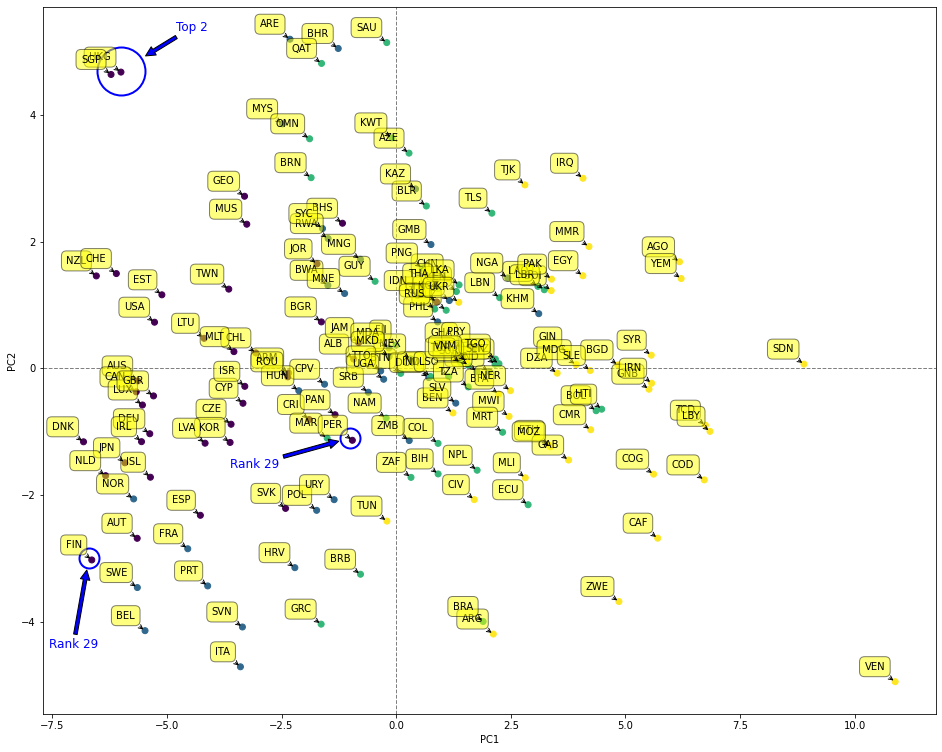

In [18]:
# label the points
plt.figure(figsize=(16,13))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=q)

for label, x, y in zip(data_2018['ISO_Code'], X_pca[:, 0], X_pca[:, 1]):
    plt.annotate(
        label,
        xy = (x, y), xytext = (-10, 10),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
    
# add annotation    
circle_rad = 24  # This is the radius, in points
plt.plot(-6, 4.7, 'o',
        ms=circle_rad * 2, mec='b', mfc='none', mew=2)

plt.annotate('Top 2', (-6, 4.7), xytext=(55, 40),
            textcoords='offset points',
            color='b', size='large',
            arrowprops=dict(
                arrowstyle='simple,tail_width=0.3,head_width=0.8,head_length=0.8',
                facecolor='b', shrinkB=circle_rad * 1.2)
)

circle_rad1 = 10  # This is the radius, in points
plt.plot(-6.7, -3, 'o',
        ms=circle_rad1 * 2, mec='b', mfc='none', mew=2)

plt.annotate('Rank 29', (-6.7, -3), xytext=(-40, -90),
            textcoords='offset points',
            color='b', size='large',
            arrowprops=dict(
                arrowstyle='simple,tail_width=0.3,head_width=0.8,head_length=0.8',
                facecolor='b', shrinkB=circle_rad1 * 1.2)
)

plt.plot(-1, -1.1, 'o',
        ms=circle_rad1 * 2, mec='b', mfc='none', mew=2)

plt.annotate('Rank 29', (-1, -1.1), xytext=(-120, -30),
            textcoords='offset points',
            color='b', size='large',
            arrowprops=dict(
                arrowstyle='simple,tail_width=0.3,head_width=0.8,head_length=0.8',
                facecolor='b', shrinkB=circle_rad1 * 1.2)
)


    
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower right", title="Quartile")
plt.axvline(0, linewidth=1, color='grey', linestyle='--')
plt.axhline(0, linewidth=1, color='grey', linestyle='--')
plt.xlabel('PC1')
plt.ylabel('PC2')
ax.add_artist(legend1)
plt.show();

In [19]:
def plot_econ_freedom_pca(pca, top_k = 2):
    fig, ax = plt.subplots(figsize=(15, 8))
    plt.imshow(pca.components_[0:top_k], interpolation = 'none', cmap = 'plasma')
    feature_names=list(X.columns)
    plt.xticks(np.arange(-0., len(feature_names), 1) , feature_names, rotation = 90, fontsize=12)
    plt.yticks(np.arange(0., 2, 1), ['First PC', 'Second PC'], fontsize = 16)
    plt.colorbar()
    
# plot_econ_freedom_pca(pca)

In [45]:
def biplot(score, coeff, n, maxdim, pcax, pcay, labels=None):
    zoom = 0.5
    pca1=pcax-1
    pca2=pcay-1
    xs = score[:,pca1]
    ys = score[:,pca2]
#     n = min(coeff.shape[0], maxdim)
    width = 2.0 * zoom
    scalex = width/(xs.max()- xs.min())
    scaley = width/(ys.max()- ys.min())
    text_scale_factor = 1.3
        
    fig = plt.gcf()
    fig.set_size_inches(11.5, 10)
    
    plt.scatter(xs*scalex, ys*scaley, s=18)
#     for i in range(n):
    for i in n:
        plt.arrow(0, 0, coeff[i,pca1], coeff[i,pca2],
                  color='k',alpha=0.6, head_width = 0.03 * zoom) 
        if labels is None:
            plt.text(coeff[i,pca1]* text_scale_factor, 
                     coeff[i,pca2] * text_scale_factor, 
                     "Var"+str(i+1), color='g', ha='center', va='center')
        else:
            plt.text(coeff[i,pca1]* text_scale_factor, 
                     coeff[i,pca2] * text_scale_factor, 
                     labels[i], color='g', ha='center', va='center')
    
    plt.xlim(-zoom,zoom)
    plt.ylim(-zoom,zoom)
#     plt.xlim(-0.75,0.75)
#     plt.ylim(-0.75,0.75)
    plt.xlabel("PC{}".format(pcax))
    plt.ylabel("PC{}".format(pcay))
    plt.title(label="Biplot",fontsize=18)
    plt.grid()

#### Below variable factor map suggests that top 50% of the countries with higher economic freedom have higher value in protection of property rights, judicial independence, itegrity of the legal system, and impartial courts, which are essentially describing a government's ability to reinforce justice and law without bias. Interestingly, countries ranked lower tend to have higher value of index in government consumption and transfers and susidies(area 1: size of government). It means these lower ranking countries have government which spend less and are less likely to transfer wealth from some people to others. These in fact should have helped to boost economic freedom. Thus, the importance of having a trust worthy government with sound and impartial legal system outweights the importance of the way government managing and distributing capital.

" When government spending increases relative to spending by individuals, households, and businesses, government decision-making is substituted for personal choice and economic freedom is reduced.When government consumption is a larger share of the total, political choice is substituted for personal choice. Similarly, when governments tax some people in order to provide transfers to others, they reduce the freedom of individuals to keep what they earn. Therefore, countries with low levels of government spending as a share of the total, a smaller government enterprise sector, and lower marginal tax rates earn the highest ratings in this area."

explained_variance_ratio: [0.28364805 0.09067877 0.07048744 0.05788128 0.0457308  0.03716067
 0.0318028  0.02979481 0.02707337 0.0250661  0.02391063 0.02255819
 0.02044172 0.0185319  0.01722931 0.01583437 0.01436418 0.01380868
 0.01313706 0.01245    0.0122166  0.01150969 0.01026863]
sum of explained variance ratios: 0.9055850508990068
singular values: [44.9649119  25.42357691 22.4150505  20.31201055 18.05461531 16.27517337
 15.05624031 14.5731747  13.89168864 13.36679372 13.0550738  12.68048688
 12.07098018 11.49327669 11.08199031 10.62390611 10.11868798  9.92110273
  9.67682435  9.42038363  9.33166133  9.05765408  8.55539533]


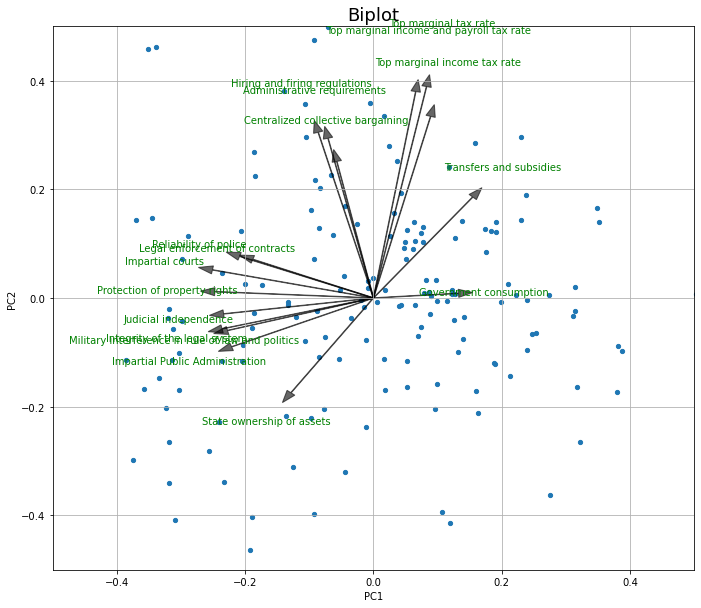

In [46]:
feature_subset_count = 44
# plot_econ_freedom_pca(pca)
feature_names=list(X.columns)

### Feel free to use this routine to plot your own biplots!
plt.figure()

feature_subset = slice(0, feature_subset_count, 1)

biplot(X_pca, np.transpose(pca.components_[0:2, feature_subset]), [0,1,3,4,5,6,7,8,9,10,11,12,33,34,38,14,41],
       feature_subset_count, 1, 2, labels=feature_names[feature_subset])

print("explained_variance_ratio:", pca.explained_variance_ratio_)
print("sum of explained variance ratios:", np.sum(pca.explained_variance_ratio_))
print("singular values:", pca.singular_values_)  

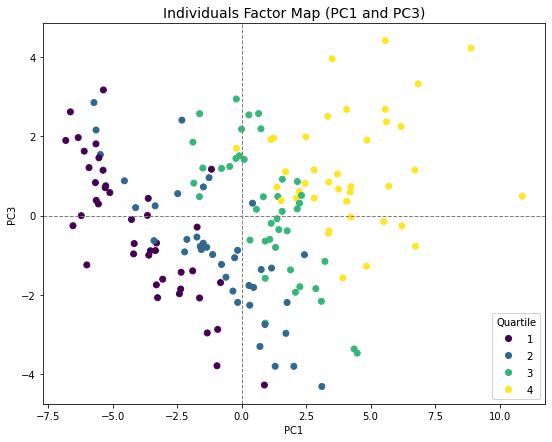

In [22]:
# Visualize the data in the projection on PC1 and PC3
# with legend

fig, ax = plt.subplots(figsize=(9, 7))
scatter = ax.scatter(X_pca[:,0], X_pca[:,2], c=q)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower right", title="Quartile")
ax.add_artist(legend1)
plt.axvline(0, linewidth=1, color='grey', linestyle='--')
plt.axhline(0, linewidth=1, color='grey', linestyle='--')
plt.title(label="Individuals Factor Map (PC1 and PC3)",fontsize=14)
plt.xlabel('PC1')
plt.ylabel('PC3')
plt.show()

#### In the plane of PC1 and PC3, countries in the last quartile are now concerntrated in the top right quadrant of the graph. These countries have less freedom of foreigners to visit and higher tariff rates, meaning that freedom of exchange goods and human capital across national boundaries is restricted.

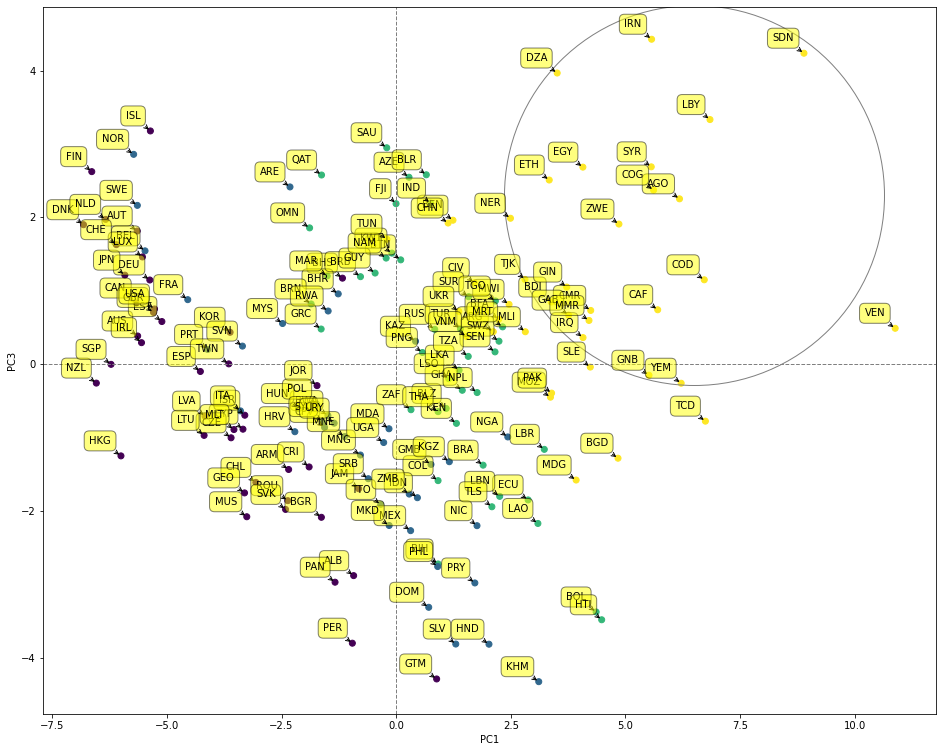

In [36]:
# label the points
plt.figure(figsize=(16,13))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 2], c=q)

for label, x, y in zip(data_2018['ISO_Code'], X_pca[:, 0], X_pca[:, 2]):
    plt.annotate(
        label,
        xy = (x, y), xytext = (-10, 10),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
    
circle_rad1 = 190  # This is the radius, in points
plt.plot(6.5, 2.3, 'o',
        ms=circle_rad1 * 2, mec='grey', mfc='none', mew=1,linestyle='--')
    
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower right", title="Quartile")
plt.axvline(0, linewidth=1, color='grey', linestyle='--')
plt.axhline(0, linewidth=1, color='grey', linestyle='--')
plt.xlabel('PC1')
plt.ylabel('PC3')
ax.add_artist(legend1)
plt.show();

explained_variance_ratio: [0.28364805 0.09067877 0.07048744 0.05788128 0.0457308  0.03716067
 0.0318028  0.02979481 0.02707337 0.0250661  0.02391063 0.02255819
 0.02044172 0.0185319  0.01722931 0.01583437 0.01436418 0.01380868
 0.01313706 0.01245    0.0122166  0.01150969 0.01026863]
sum of explained variance ratios: 0.9055850508990068
singular values: [44.9649119  25.42357691 22.4150505  20.31201055 18.05461531 16.27517337
 15.05624031 14.5731747  13.89168864 13.36679372 13.0550738  12.68048688
 12.07098018 11.49327669 11.08199031 10.62390611 10.11868798  9.92110273
  9.67682435  9.42038363  9.33166133  9.05765408  8.55539533]


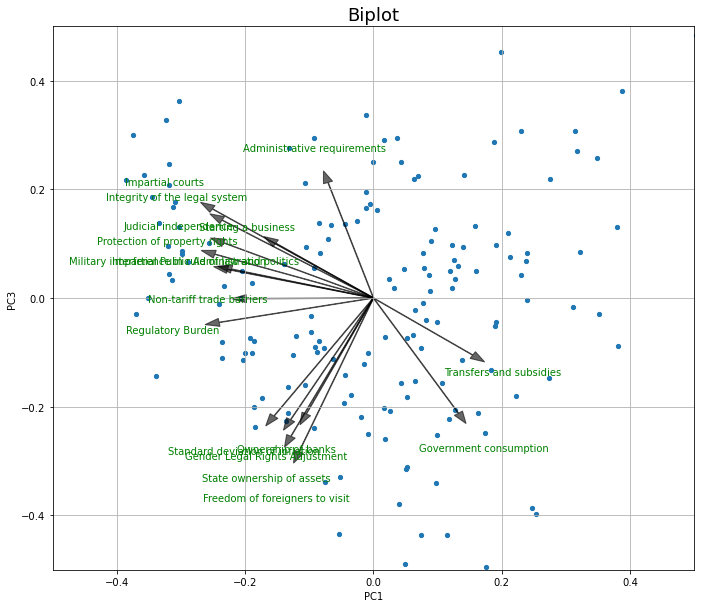

In [47]:
feature_subset_count = 44
# plot_econ_freedom_pca(pca)
feature_names=list(X.columns)

### Feel free to use this routine to plot your own biplots!
plt.figure()

feature_subset = slice(0, feature_subset_count, 1)

biplot(X_pca, np.transpose(pca.components_[0:3, feature_subset]), [0,1,6,7,8,9,10,11,15,17,23,41,40,39,38,29,28],
       feature_subset_count, 1, 3, labels=feature_names[feature_subset])

print("explained_variance_ratio:", pca.explained_variance_ratio_)
print("sum of explained variance ratios:", np.sum(pca.explained_variance_ratio_))
print("singular values:", pca.singular_values_)  

### 3. Clustering

In [25]:
# use kmeans to cluster the PCA reduced variables
# use elbow method to find the optimal number of clusters

inertia = []
K = np.arange(1, 21)
for k in K:
    kmeans = KMeans(n_clusters=k, n_init=100, random_state=RANDOM_STATE).fit(X_pca)
    inertia.append(np.sqrt(kmeans.inertia_))
print(inertia)

[80.34307837522854, 71.37394785168368, 68.05541008811616, 65.5957180707577, 63.58243112361794, 62.143935708317365, 61.12161086147865, 59.95737135277911, 58.97471793113097, 57.93926317946586, 56.92801768348048, 56.06665239093033, 55.16864708422624, 54.3445121758075, 53.68332050542369, 53.050853964256575, 52.332387314998364, 51.76861003569935, 51.314127343018484, 50.36926030371506]


#### Elbow method suggests 2 clusters is optimal.

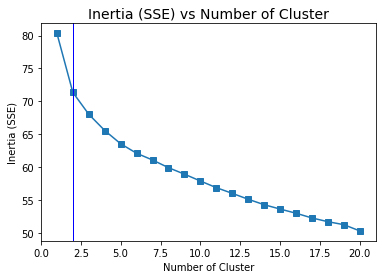

In [26]:
plt.plot(K, inertia, marker='s')
plt.axvline(2, linewidth=1, color='b')
plt.xlim(0,21)
plt.xlabel("Number of Cluster")
plt.ylabel("Inertia (SSE)")
plt.title(label="Inertia (SSE) vs Number of Cluster",fontsize=14)
plt.show();

#### Partitioning the data into 2 clusters per elbow method makes sense, because as mentioned before we can see that majority of the countries in quartile 1 and 2 are positioned on the left side of the plane. The rest of the countries in quartile 3 and 4 are positioned on the right side of the plane.

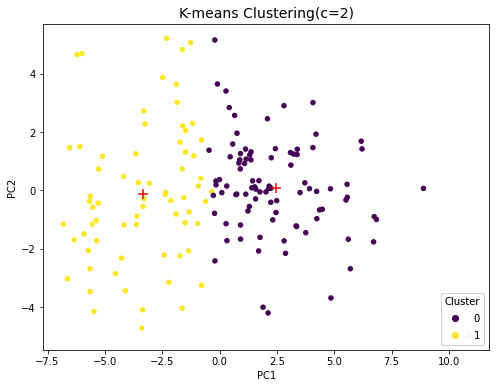

In [27]:
# with 2 clusters
kmeans = KMeans(n_clusters=2, n_init=100, random_state=RANDOM_STATE)
kmeans.fit(X_pca)
cluster_labels = kmeans.labels_
centroids = kmeans.cluster_centers_

fig, ax = plt.subplots(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, s=20)#,  cmap='viridis');
legend2 = ax.legend(*scatter.legend_elements(),
                    loc="lower right", title="Cluster")

plt.scatter(centroids[:,0] , centroids[:,1] , s = 100, color = 'r', marker='+')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(label="K-means Clustering(c=2)",fontsize=14)
ax.add_artist(legend2)
plt.show()

#### How about using silhouette method in finding optimal number of clusters?

#### 4 clusters is a bad pick for the given data due to the presence of clusters with below average silhouette scores and also due to wide fluctuations in the size of the silhouette plots. 2 cluser looks the most ideal as all silhouette scores are above average and the width of each cluster in the silhouette plot is similar. This reflects the same result from the elbow method. However, the issue with 2 cluster is that we are unable to analyze the dissimilarities in terms of characteristics among countries ranked in the similar positions. For instance, both Finland and Peru rank 26th, but they are far apart in the plane of PC1 and PC2. Thus, based on the silhouette scores we can try to cluster the countries into 3 or 5 groups as the next best choices and observe the outcome.

For n_clusters = 2 The average silhouette_score is : 0.17777254105208756
For n_clusters = 3 The average silhouette_score is : 0.12858001890619228
For n_clusters = 4 The average silhouette_score is : 0.14978019707766826
For n_clusters = 5 The average silhouette_score is : 0.125614879611818
For n_clusters = 6 The average silhouette_score is : 0.10344341867562055


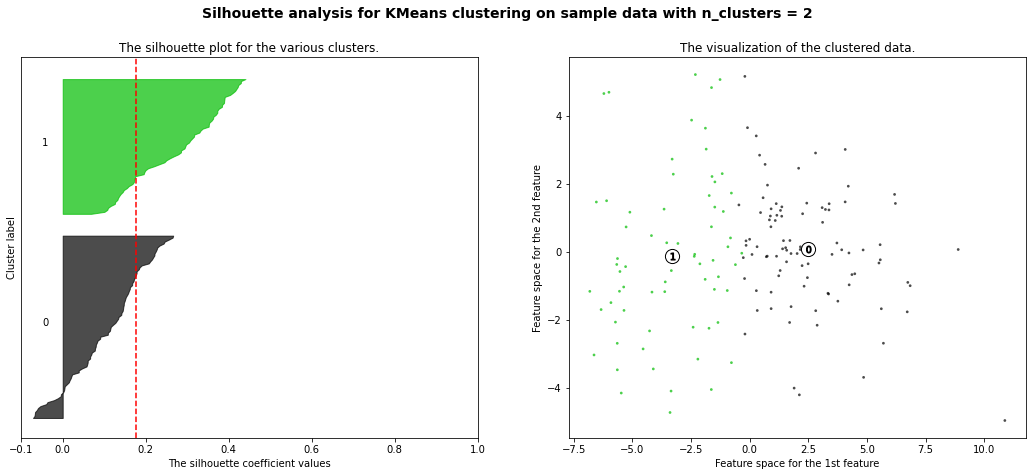

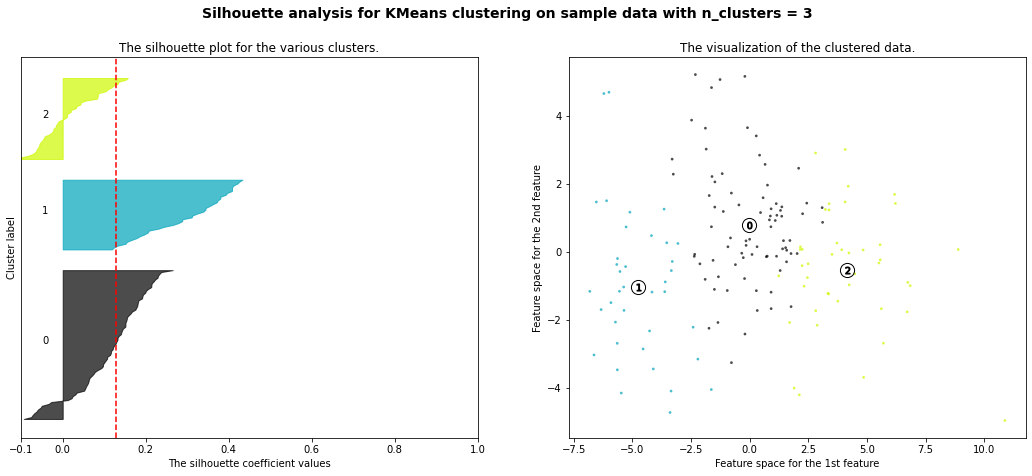

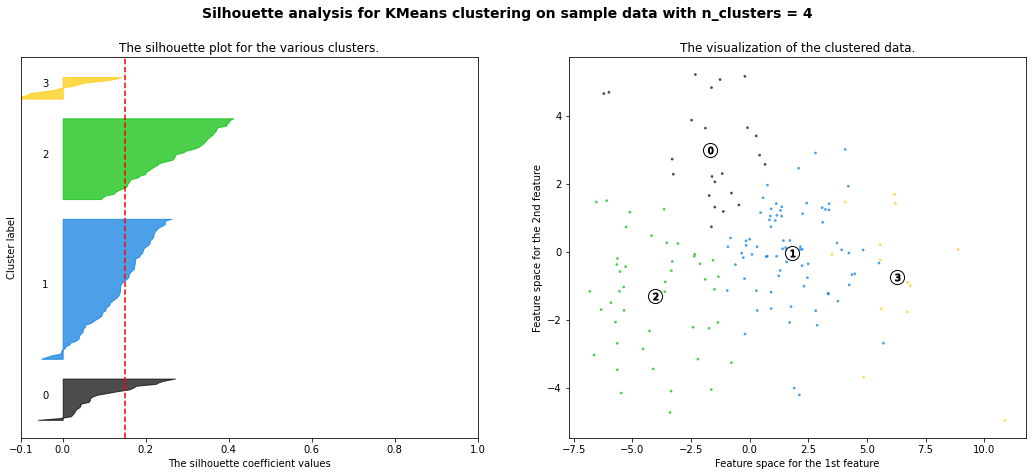

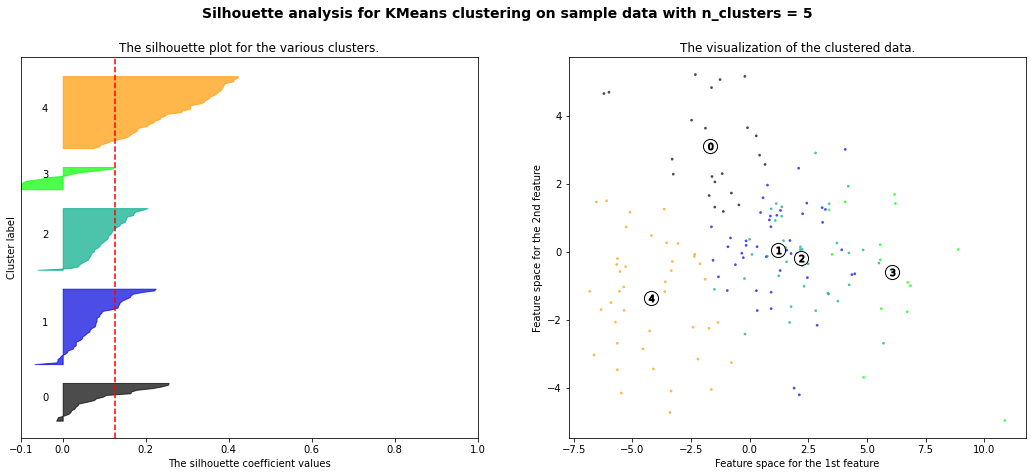

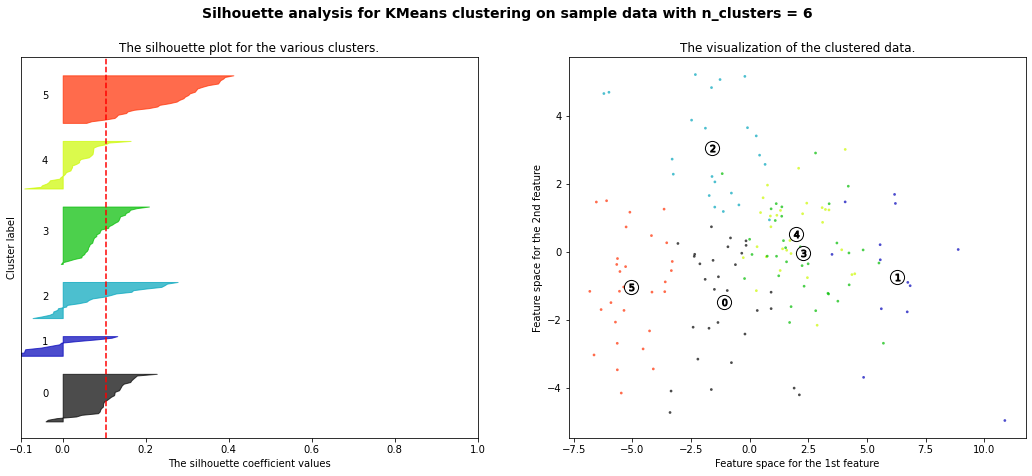

In [28]:
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=RANDOM_STATE)
    cluster_labels = clusterer.fit_predict(X_pca)

    silhouette_avg = silhouette_score(X_pca, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_pca, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X_pca[:, 0], X_pca[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

#### Based on the biplot (PC1 and PC2) and below graph (3 clusters):
- **Cluster 0** is made of countries such as HongKong, Singapore, US, UK, and Sweden. This group is characterized by strong protection of property rights, an independent and unbiased judiciary, and impartial and effective enforcement of the law. 
- **Cluster 1** is made of countries such as United Arab Emirates, Qatar, Malaysia, Tunisia, Barbados and Pakistan. This group is characterized by low tax rate and relatively less restrictive for business entering into markets.(neg?)
- **Cluster 2** is made of countries such as Brazil, Argentina, Sudan, Venezuela, Congo and Irag. This group is characterized by rather unstable political status, inability to protect citizens' legal rights and to enforce justice and impartial laws. Government has little to spend due to weak economy.

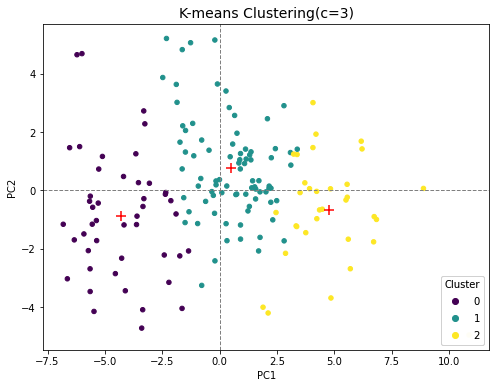

In [29]:
# with 3 clusters
kmeans = KMeans(n_clusters=3, n_init=100, random_state=RANDOM_STATE)
kmeans.fit(X_pca)
cluster_labels = kmeans.labels_
centroids = kmeans.cluster_centers_

fig, ax = plt.subplots(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, s=20)#,  cmap='viridis');
legend3 = ax.legend(*scatter.legend_elements(),
                    loc="lower right", title="Cluster")

plt.scatter(centroids[:,0] , centroids[:,1] , s = 100, color = 'r', marker='+')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.axvline(0, linewidth=1, color='grey', linestyle='--')
plt.axhline(0, linewidth=1, color='grey', linestyle='--')
plt.title(label="K-means Clustering(c=3)",fontsize=14)
ax.add_artist(legend3)
plt.show()

### Use a different clustering method, Agglomerative Clustering

In [30]:
from sklearn.preprocessing import normalize
data_scaled = normalize(X_pca)

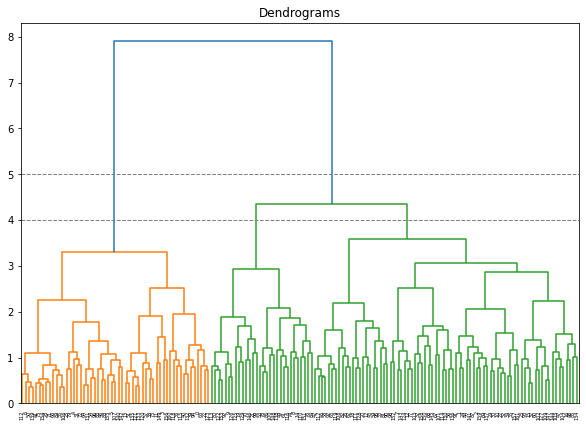

In [31]:
from scipy.cluster import hierarchy 
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")
plt.axhline(5, linewidth=1, color='grey', linestyle='--')
plt.axhline(4, linewidth=1, color='grey', linestyle='--')
dend = hierarchy.dendrogram(hierarchy.linkage(data_scaled, method='ward'))

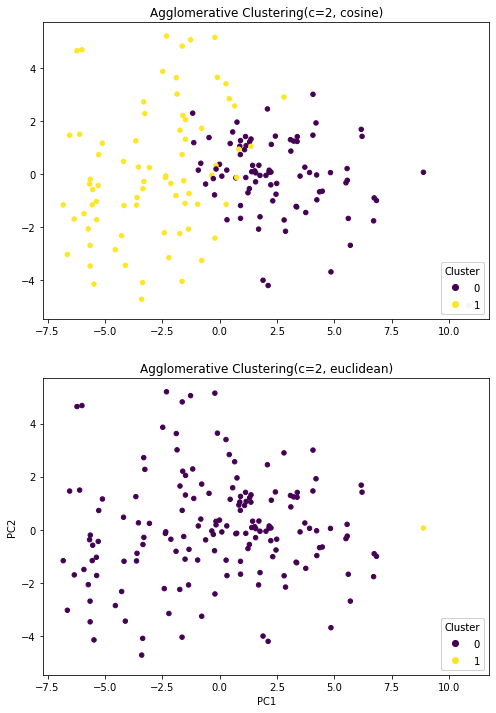

In [32]:
# 2 clusters 
fig, axs = plt.subplots(2,figsize=(8, 12))
for index, metric in enumerate(["cosine", "euclidean"]):
    
    
    ac = AgglomerativeClustering(n_clusters = 2, affinity= metric, linkage='average')
    cluster_labels = ac.fit_predict(X_pca)
    
    scatter = axs[index].scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, s=20)
    legend2 = axs[index].legend(*scatter.legend_elements(),
                        loc="lower right", title="Cluster")

    axs[index].add_artist(legend2)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    axs[index].title.set_text(f"Agglomerative Clustering(c=2, {metric})")
plt.show()

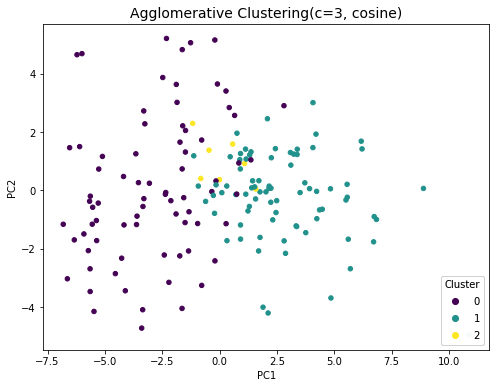

In [37]:
# 3 clusters 
ac = AgglomerativeClustering(n_clusters = 3, affinity= "cosine", linkage='average')
cluster_labels = ac.fit_predict(X_pca)

fig, ax = plt.subplots(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, s=20)
legend2 = ax.legend(*scatter.legend_elements(),
                    loc="lower right", title="Cluster")

ax.add_artist(legend2)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(label="Agglomerative Clustering(c=3, cosine)",fontsize=14)
plt.show()